# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [33]:
# imports
import panel as pn
from panel.interact import interact
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


In [34]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [35]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [36]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [37]:
# Getting the data from the top 10 expensive neighbourhoods
neighbourhood=to_data.groupby(['neighbourhood']).mean().reset_index()
neighbourhood.sort_values(by='average_house_value',ascending=False,inplace=True)



# Calculate the mean number of dwelling types units per year
mean_dwell_data = to_data.groupby(['year']).mean()
mean_dwell_data.drop(columns=['average_house_value', 'shelter_costs_owned','shelter_costs_rented'],inplace=True)


# Calculate the average monthly shelter costs for owned and rented dwellings
shelter_data=to_data[['shelter_costs_owned','shelter_costs_rented']].groupby(['year']).mean()


In [38]:
join_data=pd.merge(df_neighbourhood_locations, neighbourhood, on='neighbourhood')
neighbour_data=to_data[['neighbourhood','average_house_value']]
dwell_data=to_data.drop(columns=['average_house_value', 'shelter_costs_owned',
                   'shelter_costs_rented'])

### Panel Visualization Functions

In [72]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    neighbour_map= px.scatter_mapbox(
    join_data,
    lat="lat",
    lon="lon",
    color="average_house_value"
    )
    return neighbour_map

def create_bar_chart(data, year, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    x=list(data.columns)
    y=data.loc[year].values.tolist()
    bar_char = plt.figure()
    bar_char.add_subplot(111).bar(x,y,color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Dwelling Types in Toronto in {year}',fontweight='bold')
    plt.xticks(rotation=90)
    plt.plot(range(0, 20))


    scale_factor = 1

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)

#     plt.axis([100, 300, 100, 300])

    plt.close(bar_char)
    return bar_char


def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    line_char = plt.figure()
    line_char.add_subplot(111).plot(data,color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title,fontweight='bold')

    plt.close(line_char)
    return line_char


def hv_bar_plot():
    hv_bar=dwell_data.hvplot.bar(
        groupby='neighbourhood',frame_height=250, 
        frame_width=500,xlabel='Year',ylabel='Dwelling Type Units',rot=90
    )
    return hv_bar

def hv_line_plot():
    hv_line = neighbour_data.hvplot(
        xlabel='Year',ylabel='Avg. House Value',groupby='neighbourhood',frame_width=500
    )
    return hv_line
    

def expensive_neighbour():
    expensive_n = neighbourhood['average_house_value'].head(10).hvplot.bar(
        xlabel='Neighbourhood',frame_height=250, frame_width=500,
        ylabel='Avg. House Value',rot=90,title='Top 10 Expensive Neighbourhoods in Toronto')
    return expensive_n
    
def average_house_value():
    """Average house values per year."""
    
    return to_data['average_house_value'].groupby(['year']).mean()

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    return to_data['average_house_value'].groupby(['neighbourhood']).mean()

def number_dwelling_types():
    """Number of dwelling types per year"""
    d_data=to_data.drop(columns=['average_house_value', 'shelter_costs_owned','shelter_costs_rented'])
    return d_data.groupby(['year']).sum()


def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    return neighbourhood.head(10)



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [73]:
# Create a Title for the Dashboard
dashboard_title='# Real Estate Analysis of Toronto'
title = pn.pane.Markdown(
    """
    # Real Estate Analysis of Toronto
    """,
    width=800
)

# Define a welcome text
# YOUR CODE HERE!

# Create a tab layout for the dashboard
title_column = pn.Column(
    dashboard_title
)
title_column
bar_column = pn.Column(
    "## Dwelling Types Bar Charts", 
    pn.Row(
        create_bar_chart(number_dwelling_types(), 2001, '2001','Dwelling Types Units','r'),
        create_bar_chart(number_dwelling_types(), 2006, '2006','Dwelling Types Units','b'), align="center"),
    pn.Row(
        create_bar_chart(number_dwelling_types(), 2011, '2011','Dwelling Types Units','y'),
        create_bar_chart(number_dwelling_types(), 2016, '2016','Dwelling Types Units','g'), align="center"),
)
line_column = pn.Column(
    "## Shelter Costs Line Charts", 
    create_line_chart(shelter_data['shelter_costs_owned'],
                    'Average Monthly Shelter Cost for Owned Dwellings in Toronto',
                    'Year','Avg Monthly Shelter Costs','b'),
    create_line_chart(shelter_data['shelter_costs_rented'],
                  'Average Monthly Shelter Cost for Rented Dwellings in Toronto',
                  'Year','Avg Monthly Shelter Costs','y')
)
hv_column = pn.Column(
    "## Neighbourhood Analysis",
    hv_bar_plot(),hv_line_plot()
)
expensive_column = pn.Column(
    
    expensive_neighbour()
)

map_column = pn.Column(
    "## Average House Values in Toronto",
    neighbourhood_map()
)
dashboard= pn.Tabs(
    ("Bar Charts", bar_column), 
    ("Line Charts", line_column),
    ("Neighbourhood Analysis", hv_column),
    ("Map",map_column)
)



# Create the main dashboard
title_column
dashboard= pn.Tabs(
    ("Bar Charts", bar_column), 
    ("Line Charts", line_column),
    ("Neighbourhood Visualizations", hv_column),
    ("Expensive Neighbourhoods",expensive_column),
    ("Neighbourhood Map",map_column)
)
dash_title = pn.Column(
    pn.Row(title),dashboard,width=900
)


## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row(align='center')
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [2] Row(align='center')
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                [1] VSpacer()
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                [1] VSpacer()
    [3] Column
        [0] HoloViews(Bars)
    [4] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
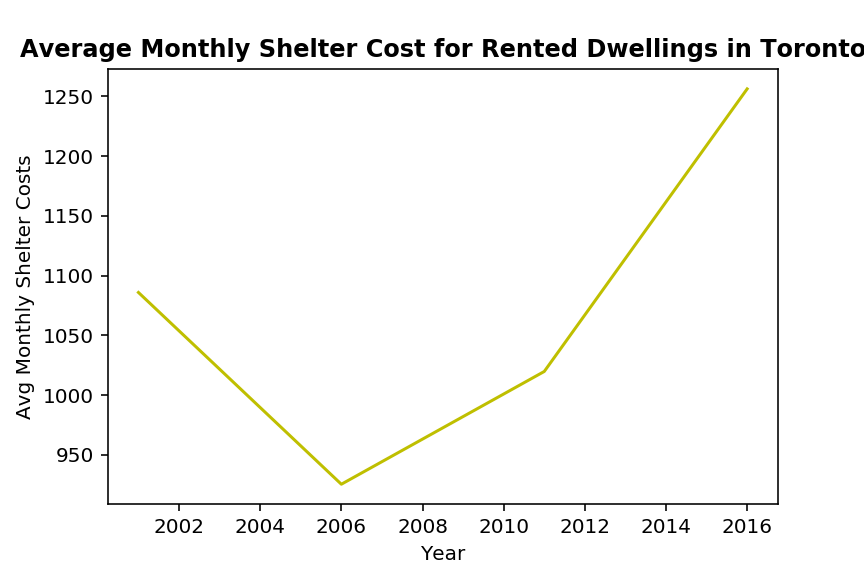
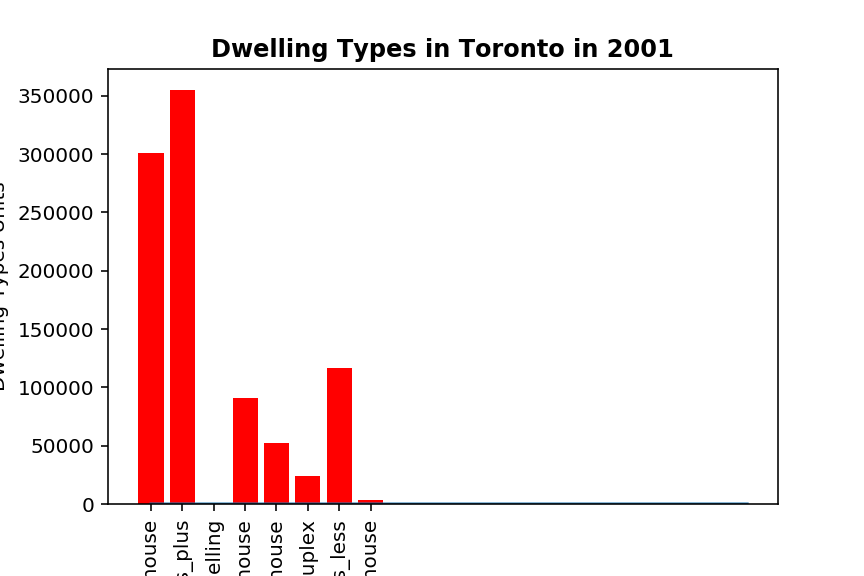
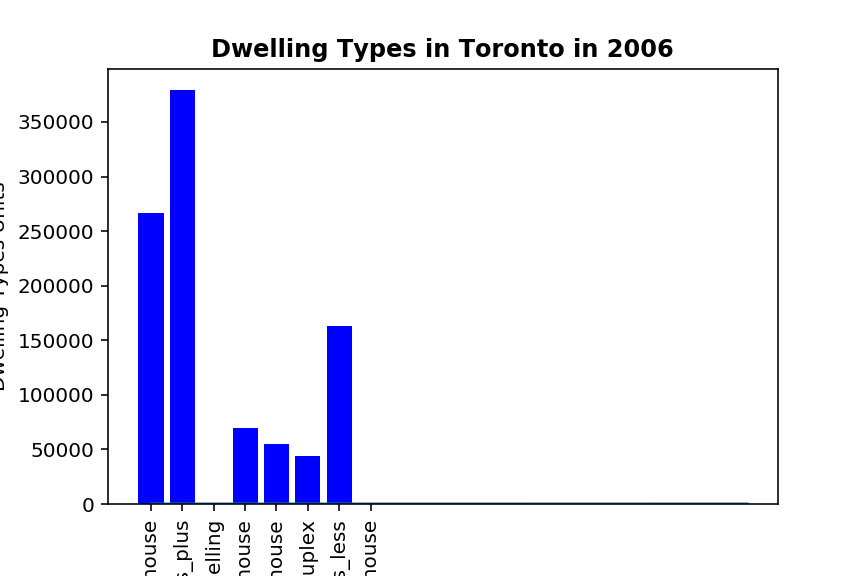
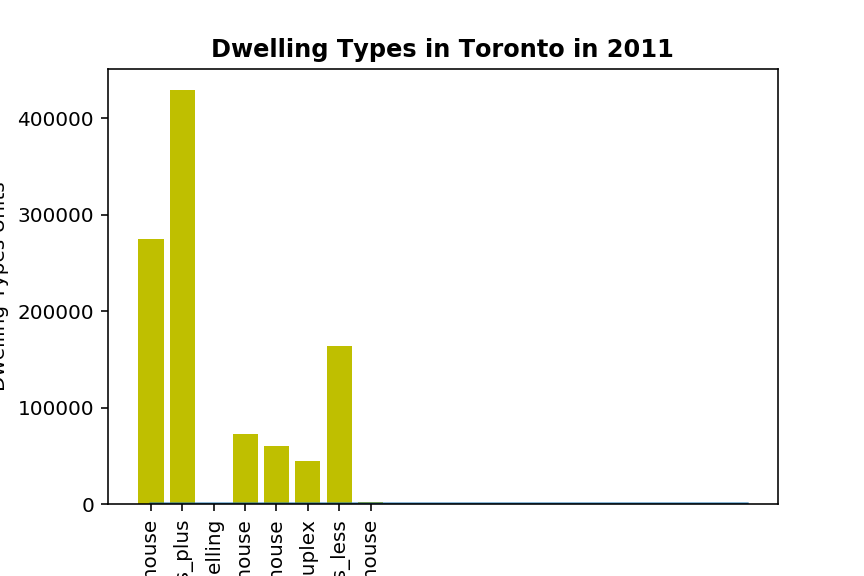
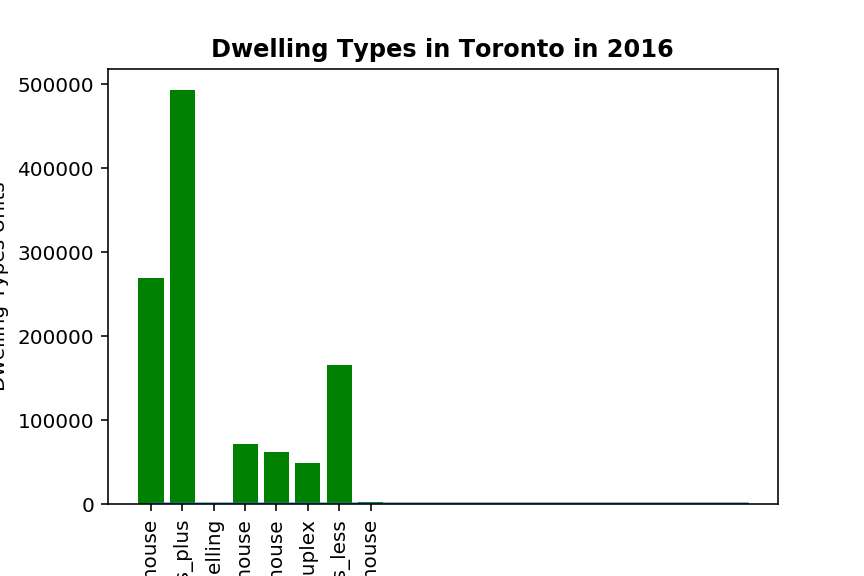
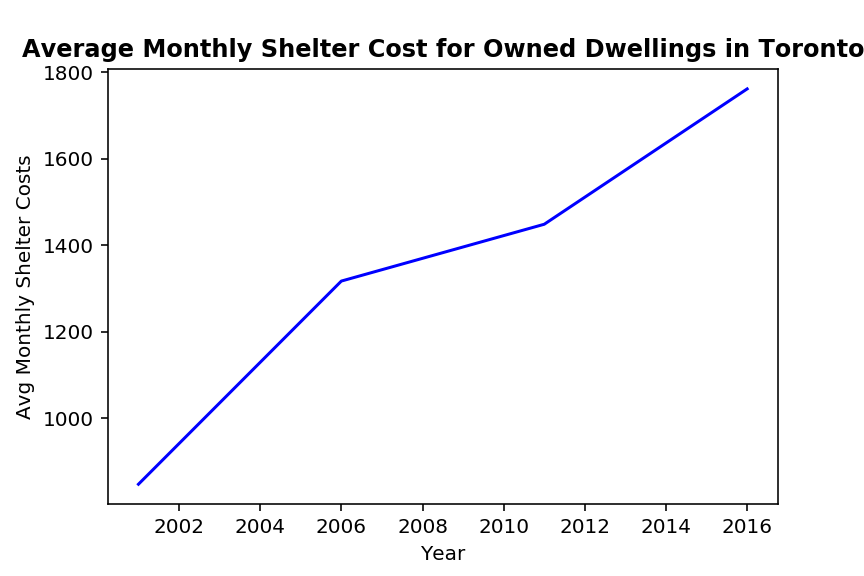

In [74]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# neighbourhood_map().show()

In [ ]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [ ]:
# average_house_value()

In [ ]:
# average_value_by_neighbourhood()

In [ ]:
# number_dwelling_types()

In [ ]:
# average_house_value_snapshot()

In [ ]:
# top_most_expensive_neighbourhoods()

In [ ]:
# sunburts_cost_analysis()